**Import Necessary Libraries**

In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

**Load The Dataset**

In [144]:
import pandas as pd
from google.colab import drive
drive.mount ('/content/drive')
weather_dataset = pd.read_csv ("/content/drive/MyDrive/DM&ML/Air Temperature Trends in Bangladesh (2020-2024).csv", index_col="DATE")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataframe Looking**

In [145]:
weather_dataset

,STATION,NAME,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,
2020-01-01,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,67,77.0,62.0
2020-01-02,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,70,82.0,61.0
2020-01-03,BGM00041891,"OSMANY INTERNATIONAL, BG",0.52,64,71.0,62.0
2020-01-04,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,66,77.0,NaN
2020-01-05,BGM00041891,"OSMANY INTERNATIONAL, BG",0.20,63,70.0,59.0
...,...,...,...,...,...,...
2024-11-06,BGM00041936,"JESSORE, BG",0.00,80,92.0,74.0
2024-11-07,BGM00041936,"JESSORE, BG",0.00,80,NaN,73.0
2024-11-08,BGM00041936,"JESSORE, BG",0.00,78,NaN,NaN


**Preprocess The Dataset**

In [146]:
# Fill issing values
weather_dataset = weather_dataset.ffill()
weather_dataset.apply(pd.isnull).sum()

# Set target variable (predict tomorrow's temperature)
weather_dataset["TARGET"] = weather_dataset["TAVG"].shift(-1)

# Drop rows with NaN TARGET
weather_dataset.dropna(inplace=True)
weather_dataset

,STATION,NAME,PRCP,TAVG,TMAX,TMIN,TARGET
DATE,,,,,,,
2020-01-01,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,67,77.0,62.0,70.0
2020-01-02,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,70,82.0,61.0,64.0
2020-01-03,BGM00041891,"OSMANY INTERNATIONAL, BG",0.52,64,71.0,62.0,66.0
2020-01-04,BGM00041891,"OSMANY INTERNATIONAL, BG",0.00,66,77.0,62.0,63.0
2020-01-05,BGM00041891,"OSMANY INTERNATIONAL, BG",0.20,63,70.0,59.0,63.0
...,...,...,...,...,...,...,...
2024-11-05,BGM00041936,"JESSORE, BG",0.00,80,91.0,72.0,80.0
2024-11-06,BGM00041936,"JESSORE, BG",0.00,80,92.0,74.0,80.0
2024-11-07,BGM00041936,"JESSORE, BG",0.00,80,92.0,73.0,78.0


**Outlier Removal**

In [147]:
Q1 = weather_dataset["TAVG"].quantile(0.25)
Q3 = weather_dataset["TAVG"].quantile(0.75)
IQR = Q3 - Q1
weather_dataset = weather_dataset[
    (weather_dataset["TAVG"] >= Q1 - 1.5 * IQR) &
    (weather_dataset["TAVG"] <= Q3 + 1.5 * IQR)
]

**Feature Engineering**

In [148]:
import numpy as np

# Ensure the index is in datetime format
weather_dataset.index = pd.to_datetime(weather_dataset.index)

# Extract basic temporal features
weather_dataset["Year"] = weather_dataset.index.year
weather_dataset["Month"] = weather_dataset.index.month
weather_dataset["Day"] = weather_dataset.index.day
weather_dataset["DayOfYear"] = weather_dataset.index.dayofyear  # Day of the year
weather_dataset["WeekOfYear"] = weather_dataset.index.isocalendar().week  # Week number
weather_dataset["IsWeekend"] = weather_dataset.index.weekday >= 5  # 1 if weekend, 0 otherwise

# Add cyclical features for Month and Day of the Year
# Months have a 12-month periodicity, and DayOfYear has a 365-day periodicity
weather_dataset["Month_Sin"] = np.sin(2 * np.pi * weather_dataset["Month"] / 12)
weather_dataset["Month_Cos"] = np.cos(2 * np.pi * weather_dataset["Month"] / 12)
weather_dataset["DayOfYear_Sin"] = np.sin(2 * np.pi * weather_dataset["DayOfYear"] / 365)
weather_dataset["DayOfYear_Cos"] = np.cos(2 * np.pi * weather_dataset["DayOfYear"] / 365)

# Drop columns if not needed
weather_dataset.drop(columns=["Year", "DayOfYear", "Month", "WeekOfYear"], inplace=True)


<ipython-input-148-7b144be87f39>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_dataset["Year"] = weather_dataset.index.year
<ipython-input-148-7b144be87f39>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_dataset["Month"] = weather_dataset.index.month
<ipython-input-148-7b144be87f39>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

**Define Predictors And Target**

In [149]:
predictors = weather_dataset.columns.difference(["TARGET", "NAME", "STATION"])
X = weather_dataset[predictors]
y = weather_dataset["TARGET"]

**Train-Test Split**

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standardize The Data For KNN**

In [151]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Initialize Models**

In [152]:
models = {
    "Ridge Regression": Ridge(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=3)
}

**Function To Calculate Accuracy**

In [153]:
def calculate_accuracy(y_true, y_pred, tolerance=2):
    correct_predictions = (abs(y_true - y_pred) <= tolerance).sum()
    total_predictions = len(y_true)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

**Store Results**

In [154]:
results = []

**Train And Evaluate Each Model**

In [155]:
for name, model in models.items():
    if name == "KNN Regressor":
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    accuracy = calculate_accuracy(y_test, predictions)

    results.append({
        "Model": name,
        "Mean Absolute Error": mae,
        "Accuracy (%)": accuracy
    })

**Convert Results To A DataFrame For Display**

In [156]:
results_df = pd.DataFrame(results)

**Display Results**

In [157]:
print("Model Performance:")
print(results_df)

Model Performance:
              Model  Mean Absolute Error  Accuracy (%)
0  Ridge Regression             1.886465     63.774403
1     Random Forest             1.794045     65.032538
2     KNN Regressor             1.847809     66.030369
3           XGBoost             1.787758     64.989154


**Predict Tomorrow's Temperature Using The Best-Performing Model (e.g., Random Forest)**

In [158]:
best_model = models["Random Forest"]
if best_model == "KNN Regressor":
    tomorrow_prediction = best_model.predict([X_test_scaled[-1]])
else:
    tomorrow_prediction = best_model.predict([X_test.iloc[-1]])

print("\nPredicted Temperature for Tomorrow:")
print(tomorrow_prediction[0])


Predicted Temperature for Tomorrow:
72.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**Plotting Actual vs Predicted Values**

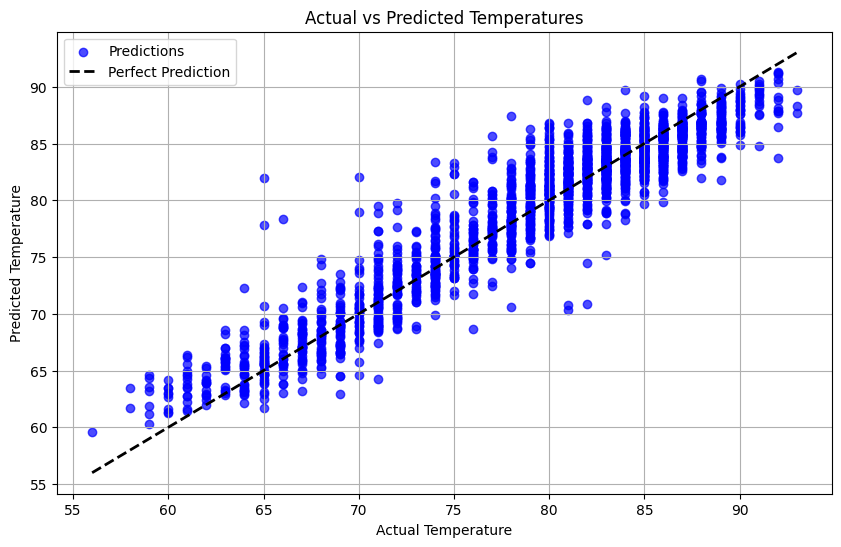

In [160]:
import matplotlib.pyplot as plt

# Create a scatter plot for Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()